In [52]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans

# Clean Tensor from Separate Data
Using Tensor constructed from separate data without anomaly injections

In [2]:
bc_data = scipy.io.loadmat("graph-gan/dataset/BlogCatalog/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(nx.info(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


/var/folders/80/w14y6f9s2_g49cyn7jpfhrfh0000gn/T/ipykernel_28945/680799908.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Text(0, 0.5, 'Frequency')

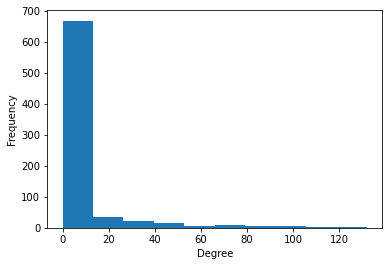

In [3]:
plt.hist(nx.degree_histogram(G))
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [3]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [4]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [5]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [6]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [7]:
with open('decomp.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()

In [8]:
core, factors = result

In [9]:
A, B, C = factors

In [10]:
A, B, C, = np.array(A), np.array(B), np.array(C)

In [11]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [12]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [13]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [14]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [15]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

151.9937847780831 5.922383915434441
28.182793891188993 3.1380770902666613


In [16]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

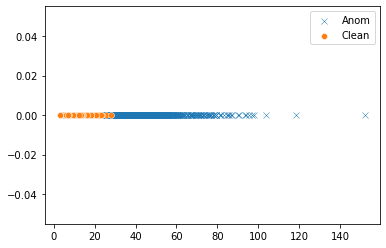

In [17]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

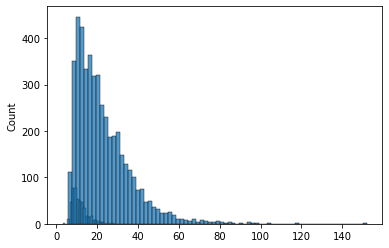

In [18]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [19]:
comb = [results_clean, results_anom]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7e492108b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7e49210f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7e49210670>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7e49221430>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7e49221700>,
 'means': []}

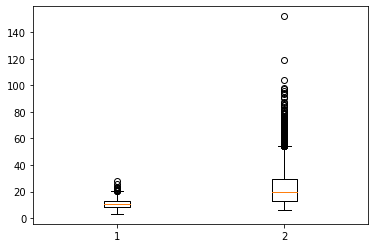

In [20]:
plt.boxplot(comb)

In [21]:
# using non-anomolous nodes from original data (no anomalies)

with open('egonets.sav', 'rb') as f:
    ego_gs = pickle.load(f)
    f.close()

print(f'Using {len(ego_gs)} egonets')

Using 10312 egonets


In [22]:
indices = np.random.randint(0, len(anom_gs), size=len(clean_gs))

sampled_anoms = np.array(anom_gs, dtype=object)[indices]

In [23]:
padded_anom = []
for gs in tqdm(sampled_anoms):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [24]:
results_anom = []
indices = np.random.randint(0, len(padded_anom), size=len(padded_clean))
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [25]:
anom_y = np.zeros(len(results_anom))

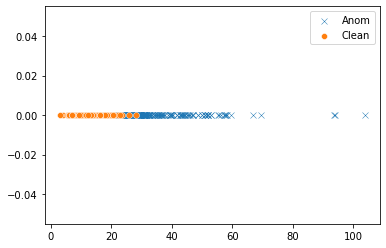

In [26]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

## Redefine Anomalies
Redefining anomalies egonets as egonets with root node as anomalous

In [27]:
bc_data = scipy.io.loadmat("graph-gan/dataset/BlogCatalog/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(nx.info(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


/var/folders/80/w14y6f9s2_g49cyn7jpfhrfh0000gn/T/ipykernel_28945/680799908.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [31]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []
    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, max_graph, roots

In [32]:
G, ego_gs, _, roots = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [42]:
roots = [int(r) for r in roots]

In [44]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [46]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/298 [00:00<?, ?it/s]

In [47]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [48]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/298 [00:00<?, ?it/s]

In [49]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [57]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

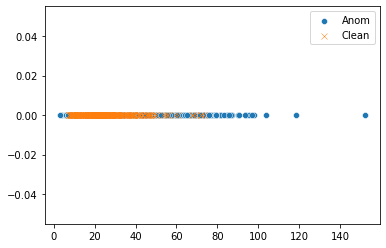

In [58]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

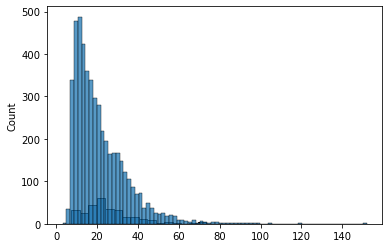

In [59]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7e0aab9100>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7e0aab9c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7e0aab9910>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7da8c24760>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7da8c24eb0>,
 'means': []}

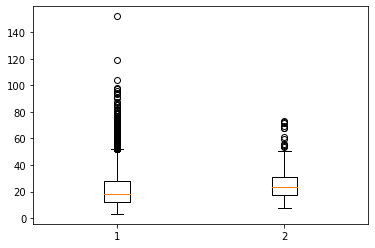

In [61]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# Clean tensor with modified data
Using "clean" tensor from redefined clean egonets. 

See BC_EgoNet_Tensor.ipynb for details. 

In [53]:
with open('decomp_mod.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

## Original Anomaly Definition

In [3]:
bc_data = scipy.io.loadmat("graph-gan/dataset/BlogCatalog/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [4]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [5]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [6]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [7]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [8]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [9]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [10]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [11]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [13]:
# storing results
saved_model = open('rec_error_clean.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [13]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

150.97796514367164 4.725902291534618
29.62832336219839 3.0777877970519065


In [15]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

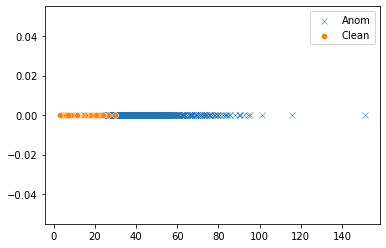

In [16]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

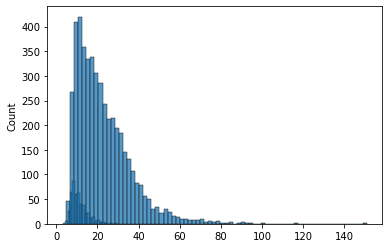

In [15]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb25c1bbfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb25ba39670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb25c1bbd00>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb25ba39b50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb25ba39e20>,
 'means': []}

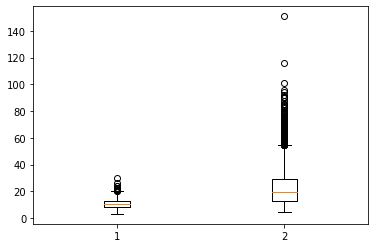

In [16]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [2]:
with open('rec_error_clean.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [3]:
results = []
results.extend(results_anom); results.extend(results_clean)

In [4]:
results = np.array(results).reshape(-1, 1)
np.random.shuffle(results)

results

array([[14.60334512],
       [67.27261932],
       [23.5805774 ],
       ...,
       [10.84822317],
       [25.45649103],
       [ 7.90701136]])

In [6]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

<AxesSubplot:>

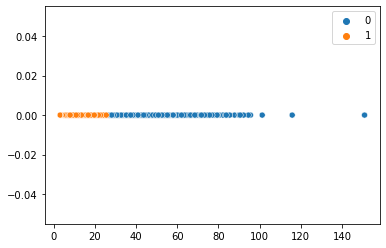

In [11]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)

## Redefined Anomalies

In [33]:
bc_data = scipy.io.loadmat("graph-gan/dataset/BlogCatalog/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(nx.info(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


/var/folders/80/w14y6f9s2_g49cyn7jpfhrfh0000gn/T/ipykernel_30150/680799908.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [34]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [35]:
G, ego_gs, roots = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [36]:
roots = [int(r) for r in roots]

In [37]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [38]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/298 [00:00<?, ?it/s]

In [39]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [40]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/298 [00:00<?, ?it/s]

In [41]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [42]:
# storing results
saved_model = open('rec_error_clean_mod.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom_mod.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [43]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

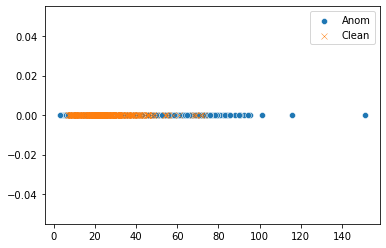

In [44]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

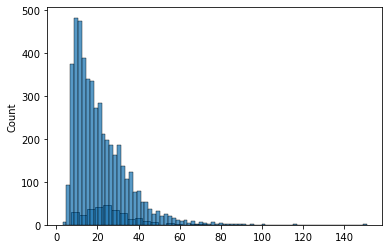

In [45]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd940a24e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd9503c04f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd940a24b80>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd9503c09d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd9503c0ca0>,
 'means': []}

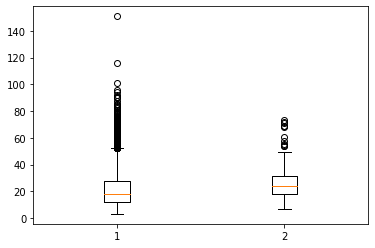

In [46]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [47]:
with open('rec_error_clean_mod.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom_mod.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [48]:
results = []
results.extend(results_anom); results.extend(results_clean)

In [49]:
results = np.array(results).reshape(-1, 1)
np.random.shuffle(results)

results

array([[30.63866399],
       [21.40855262],
       [20.17653066],
       ...,
       [21.65171333],
       [13.32984479],
       [35.97166138]])

In [50]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

<AxesSubplot:>

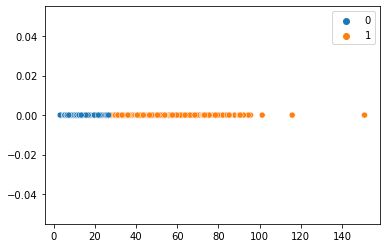

In [51]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)